In [146]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import glob
import math
import gc
from tqdm import tqdm

In [147]:
# Loading dataframe. Meidan had the cleanest clustering
df = pd.read_feather('outputs/data_median.feather')

print(df['station_0'].unique())
print(len(df['station_0'].unique()))

# What if I limit the analysis to under 500 km distance?

df = df[df['x'] <= 2500]

print(df['station_0'].unique())
print(len(df['station_0'].unique()))
print(df.loc[df['station_0']=='NCK'])

# Creating seperate dfs for each cluster
df0 = df[df['cluster']==0]
df1 = df[df['cluster']==1]

['MEK' 'LRV' 'LOV' 'LER' 'VAL' 'HAD' 'ESK' 'MAB' 'DOU' 'BFE' 'CLF' 'WNG'
 'THY' 'BEL' 'FUR' 'NGK' 'BDV' 'LON' 'SPG' 'ROE' 'SCO' 'HOV' 'JAN' 'SOR'
 'TRO' 'AND' 'JCK' 'DON' 'RVK' 'DOB' 'SOL' 'KAR' 'KEV' 'MAS' 'KIL' 'IVA'
 'ABK' 'LEK' 'MUO' 'LOZ' 'KIR' 'SOD' 'PEL' 'LYC' 'OUJ' 'HAN' 'NUR' 'UPS'
 'TAR' 'HLP' 'HRB' 'ISK' 'NCK' 'SPT' 'SUA' 'KIV' 'ODE' 'LVV' 'MOS' 'BOX'
 'LOP' 'AQU' 'EBR' 'FAR' 'BOR' 'CRK' 'GML' 'HLL' 'KVI' 'LAN' 'S01' 'OUL'
 'GCK' 'SFS' 'BFO' 'IZN' 'PAG' 'E05' 'DUR' 'PEG' 'BRZ' 'SUW' 'SZC' 'ZAG'
 'VYH' 'WIC' 'CST' 'P01' 'RNC' 'A02']
90
['MEK' 'LRV' 'LOV' 'LER' 'VAL' 'HAD' 'ESK' 'MAB' 'DOU' 'BFE' 'CLF' 'WNG'
 'THY' 'BEL' 'FUR' 'NGK' 'BDV' 'LON' 'SPG' 'ROE' 'SCO' 'HOV' 'JAN' 'SOR'
 'TRO' 'AND' 'JCK' 'DON' 'RVK' 'DOB' 'SOL' 'KAR' 'KEV' 'MAS' 'KIL' 'IVA'
 'ABK' 'LEK' 'MUO' 'LOZ' 'KIR' 'SOD' 'PEL' 'LYC' 'OUJ' 'HAN' 'NUR' 'UPS'
 'TAR' 'HLP' 'HRB' 'ISK' 'NCK' 'SPT' 'SUA' 'KIV' 'ODE' 'LVV' 'MOS' 'BOX'
 'LOP' 'AQU' 'EBR' 'FAR' 'BOR' 'CRK' 'GML' 'HLL' 'KVI' 'LAN' 'S01' 'OUL'
 'GCK' 'SF

In [148]:
print(df0.describe())
print(df1.describe())

##Shows that cluster 0 is the upper cluster and cluster 1 is the lower

                 x            y  cluster
count  1436.000000  1436.000000   1436.0
mean   1490.416381     3.881055      0.0
std     663.617081     1.410768      0.0
min      71.803101     1.106961      0.0
25%     971.560685     2.751563      0.0
50%    1607.377495     3.871023      0.0
75%    2058.459290     4.962686      0.0
max    2499.650290     8.488976      0.0
                 x            y  cluster
count  1620.000000  1620.000000   1620.0
mean   1295.131619     0.551229      1.0
std     585.412725     0.249022      0.0
min      20.083647     0.077712      1.0
25%     833.908467     0.343032      1.0
50%    1282.106583     0.538094      1.0
75%    1744.396625     0.720227      1.0
max    2499.837688     1.288854      1.0


In [149]:
# Counting which stations are in which cluster
value_counts00 = pd.DataFrame({'values0':df0['station_0'].value_counts()})
value_counts01 = pd.DataFrame({'values1':df0['station_1'].value_counts()})
value_counts10 = pd.DataFrame({'values0':df1['station_0'].value_counts()})
value_counts11 = pd.DataFrame({'values1':df1['station_1'].value_counts()})


# Combining the top sums into one sum per station for eadh cluster
value_counts0 = pd.concat([value_counts00, value_counts01], axis=1, join='outer', sort=True)
value_counts1 = pd.concat([value_counts10, value_counts11], axis=1, join='outer', sort=True)
value_counts0['upper'] = value_counts0.sum(axis=1)
value_counts1['lower'] = value_counts1.sum(axis=1)

value_counts0.drop(['values0', 'values1'], axis=1, inplace=True)
value_counts1.drop(['values0', 'values1'], axis=1, inplace=True)

In [150]:
# Merging the dataframes on the station label axis
value_counts = pd.concat([value_counts0, value_counts1], axis=1, join='outer', sort=True)
value_counts.fillna(0, inplace=True)

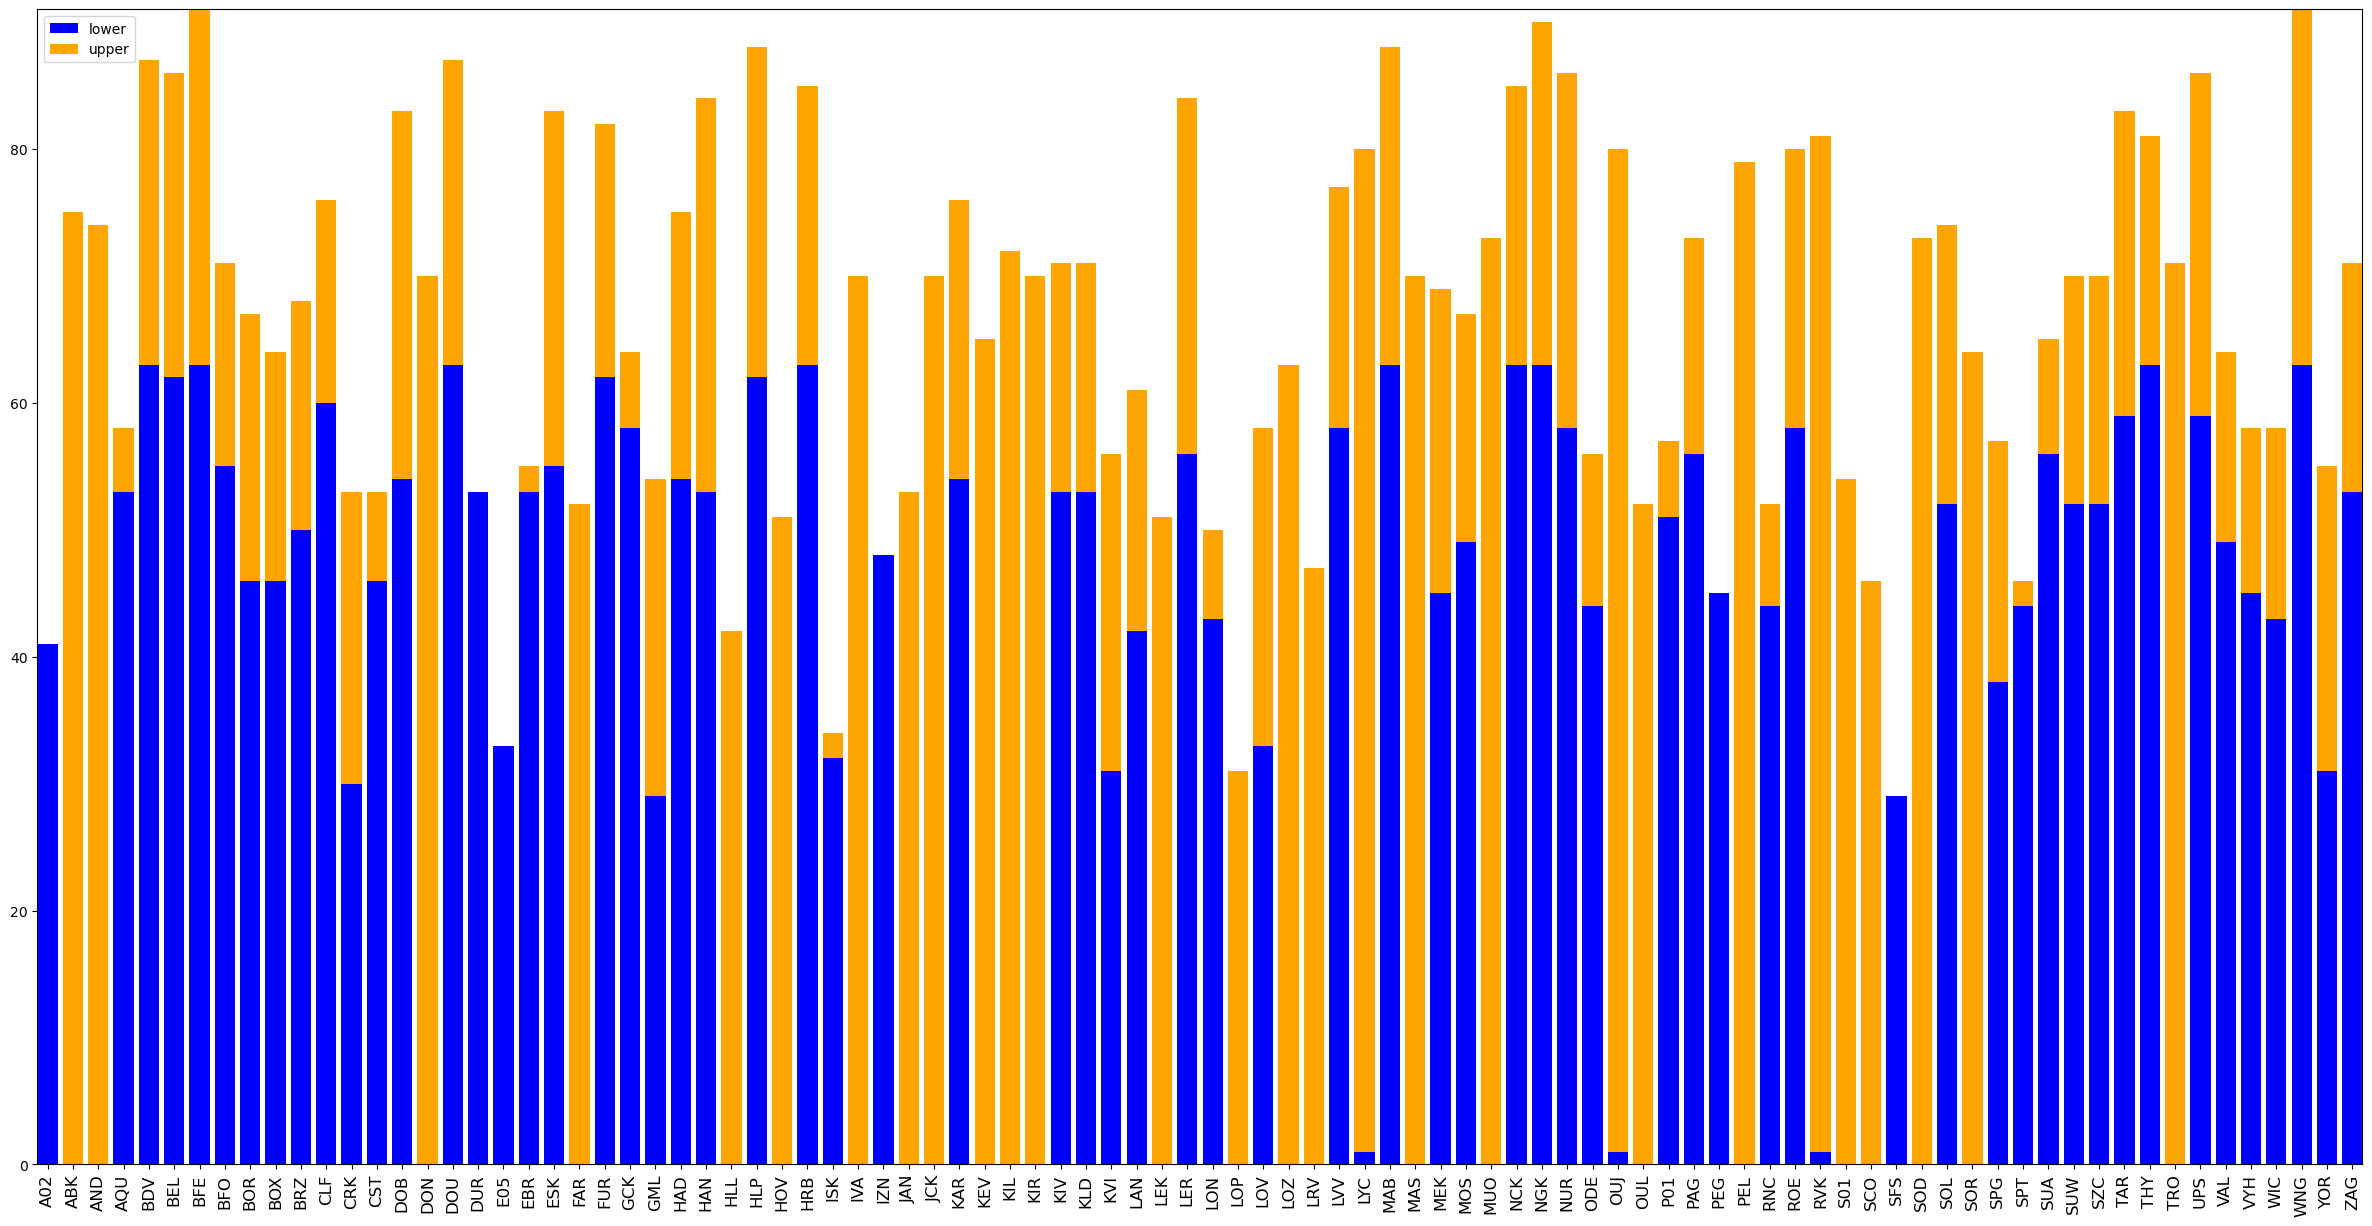

In [151]:
fig,ax = plt.subplots(figsize=(30,15))
ax.bar(value_counts.index, value_counts['lower'], color='blue', label='lower')
ax.bar(value_counts.index, value_counts['upper'], bottom=value_counts['lower'], color='orange', label='upper')
plt.margins(x=0, y=0)
plt.legend()
plt.xticks(fontsize=12, rotation=90)
plt.show()


In [152]:
# Calculating how often a station is in the upper cluster
percentage_in_upper = (value_counts['upper']/(value_counts['upper']+value_counts['lower']))*100
value_counts['perc_in_upper'] = percentage_in_upper

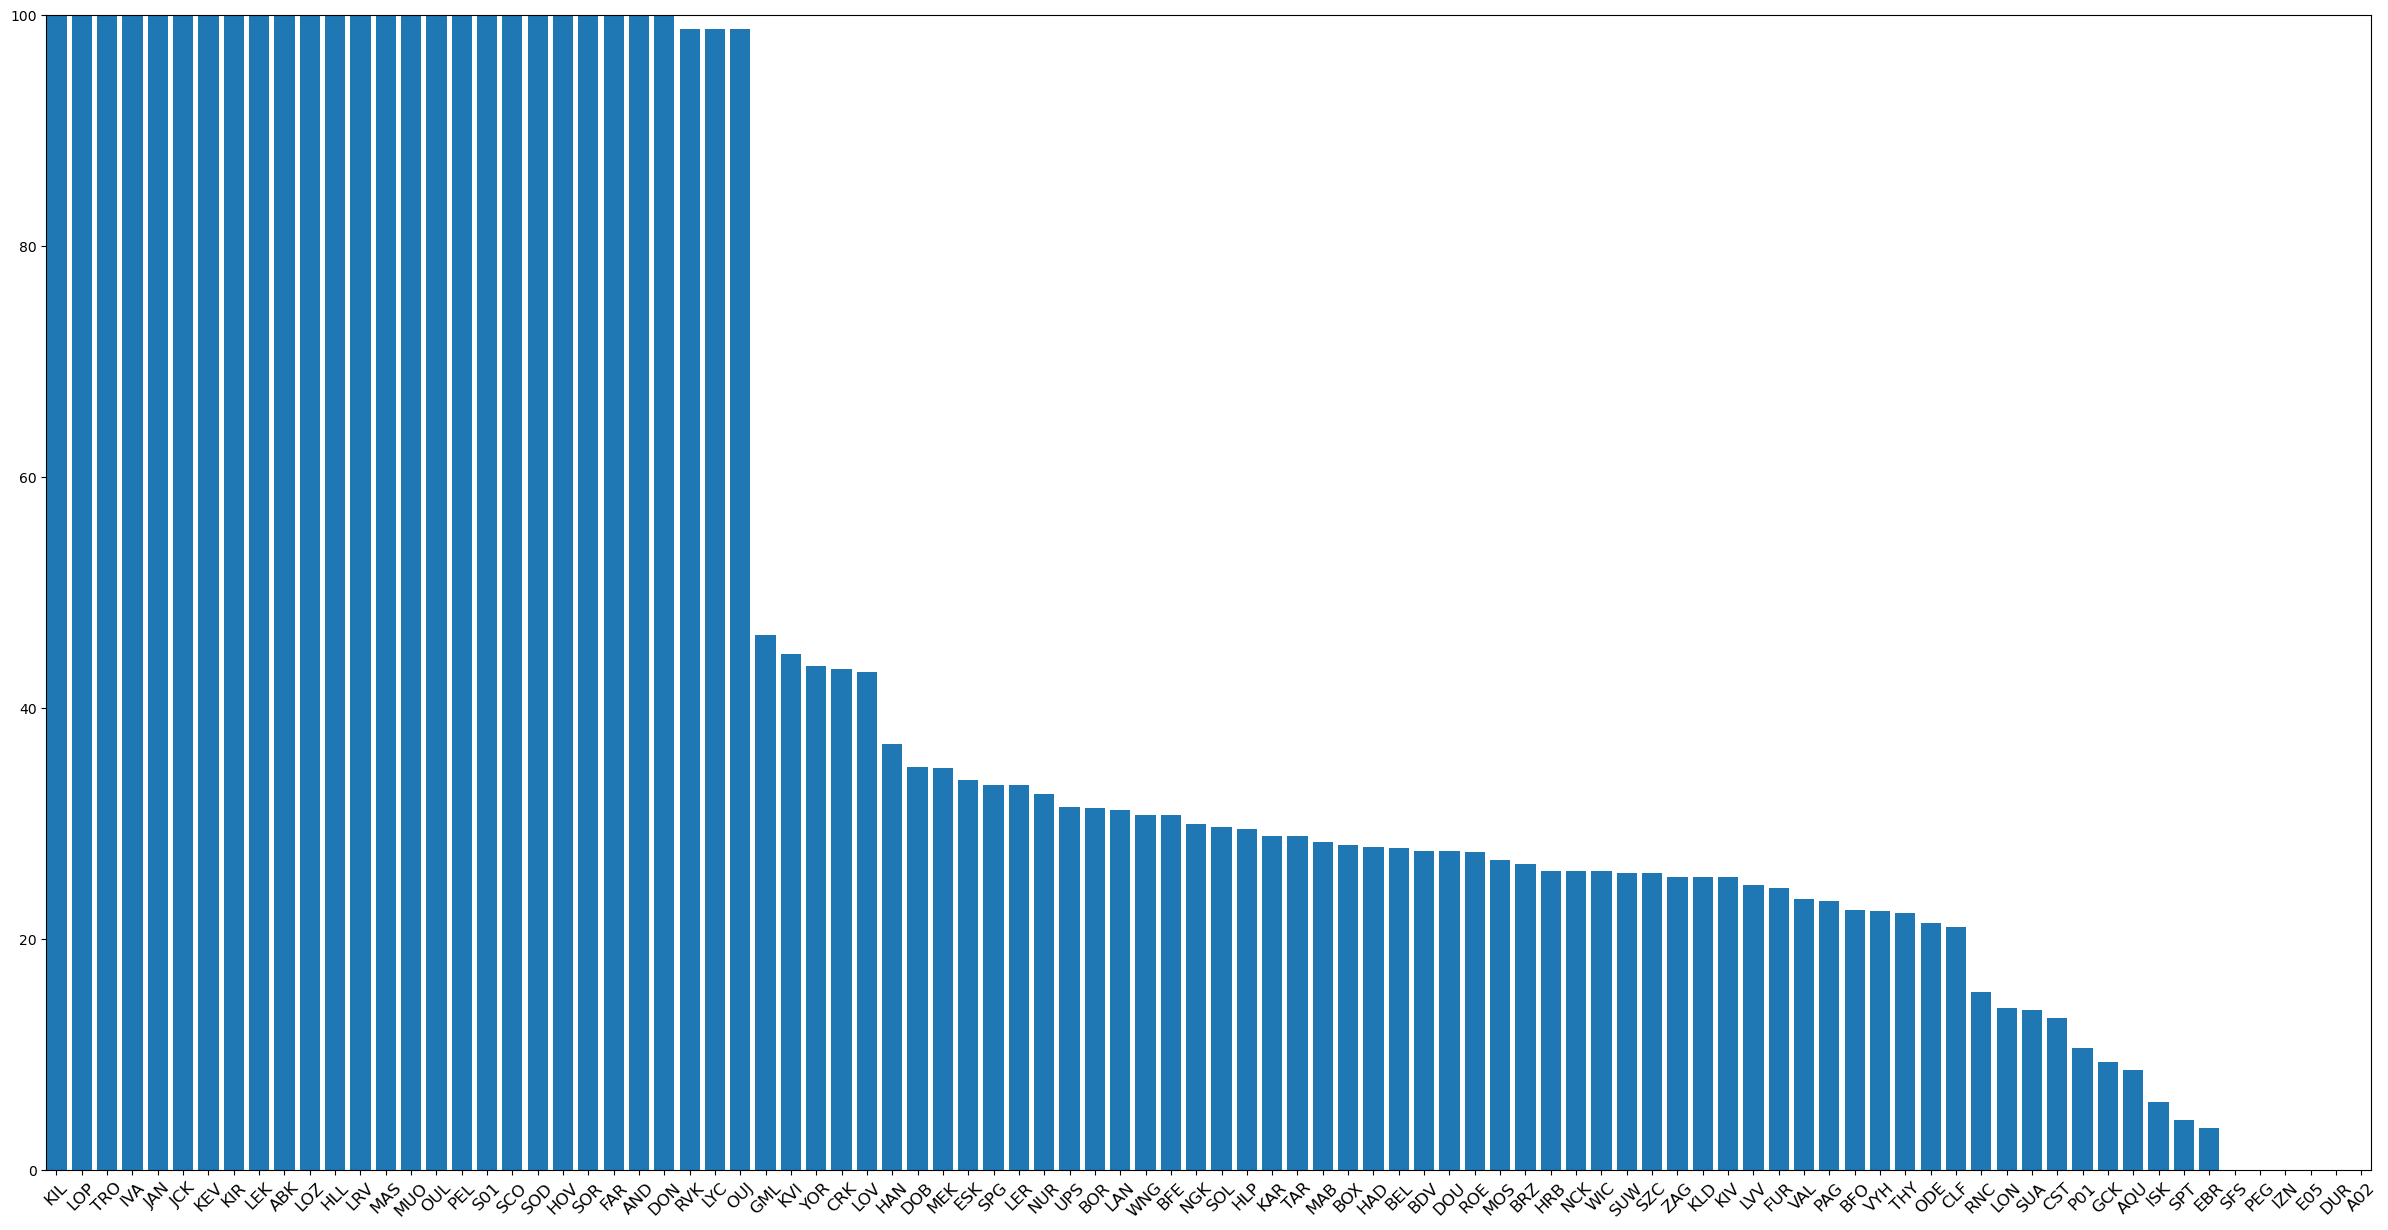

In [153]:
# Plotting the sataions based on percentage in teh upper cluster
sorted_df = value_counts.sort_values('perc_in_upper', ascending=False)
fig,ax = plt.subplots(figsize=(30,15))
ax.bar(sorted_df.index, sorted_df['perc_in_upper'])
plt.xticks(fontsize=12, rotation=45)
plt.margins(x=0, y=0)
plt.show()

In [154]:
# Segmenting the stations over 90% in the upper cluster
upper_stations = value_counts[value_counts['perc_in_upper']>=80]
mid_stations = value_counts[(value_counts['perc_in_upper']<80)&(value_counts['perc_in_upper']>=20)]
low_stations = value_counts[value_counts['perc_in_upper']<20]

upper_stations = upper_stations.reset_index(inplace=False, drop=False).rename(columns={'index':'station'})
mid_stations = mid_stations.reset_index(inplace=False, drop=False).rename(columns={'index':'station'})
low_stations = low_stations.reset_index(inplace=False, drop=False).rename(columns={'index':'station'})
value_counts = value_counts.reset_index(inplace=False, drop=False).rename(columns={'index':'station'})
print(value_counts)

   station  upper  lower  perc_in_upper
0      A02    0.0   41.0       0.000000
1      ABK   75.0    0.0     100.000000
2      AND   74.0    0.0     100.000000
3      AQU    5.0   53.0       8.620690
4      BDV   24.0   63.0      27.586207
..     ...    ...    ...            ...
87     VYH   13.0   45.0      22.413793
88     WIC   15.0   43.0      25.862069
89     WNG   28.0   63.0      30.769231
90     YOR   24.0   31.0      43.636364
91     ZAG   18.0   53.0      25.352113

[92 rows x 4 columns]


In [155]:
min_lat = 36
min_lon = 338
max_lat = 71
max_lon = 41

station_locations = pd.read_csv('supermag-stations-info.csv')

# fmt: off
stations_to_remove = ['A09', 'A10', 'A11', 'ALT', 'ARK', 'ASA', 'ASH', 'B01',
						'BJI', 'C09', 'CGO', 'CPL', 'CPY', 'CWE', 'DRB', 'E01',
						'E02', 'E03', 'E04', 'EUA', 'FTN', 'FVE', 'GLK', 'GRK',
						'KAU', 'KGD', 'KOR', 'KZN', 'LNN', 'M02', 'M11', 'MCE',
						'MHV', 'MNK', 'MSK', 'MZH', 'NAD', 'NKK', 'NR2', 'NVL',
						'PKS', 'PNL', 'POD', 'PRG', 'R01', 'R02', 'R03', 'R04',
						'R05', 'R06', 'R07', 'R08', 'R09', 'R10', 'RSV', 'SAH',
						'SAS', 'SKD', 'SMA', 'SUT', 'T26', 'T27', 'T60', 'T62',
						'TKT', 'TLK', 'TOL', 'TOR', 'TTB', 'TUL', 'W01', 'W02',
						'W03', 'W04', 'W05', 'WSE', 'WTK', 'YSS', 'KHS', 'BEY', 'KLI']
# fmt: on

station_locations = station_locations[
	station_locations['IAGA'].isin(stations_to_remove) == False
]

df = station_locations[
	(station_locations['GEOLAT'] >= min_lat)
	& (station_locations['GEOLAT'] <= max_lat)
	& (
		(station_locations['GEOLON'] >= min_lon)
		| (station_locations['GEOLON'] <= max_lon)
	)
]

df.reset_index(inplace=True, drop=True)

stations = df['IAGA'].tolist()
print(df.columns)

Index(['IAGA', 'GEOLON', 'GEOLAT', 'AACGMLON', 'AACGMLAT', 'STATION-NAME',
       'OPERATOR-NUM', 'OPERATORS'],
      dtype='object')


In [156]:
df = df[['IAGA','GEOLON', 'GEOLAT']]
df['GEOLON'] = (df['GEOLON'] + 180) % 360 - 180
df['upper_color'] = np.where(df['IAGA'].isin(upper_stations['station']), 'red', 'black')
df['mid_color'] = np.where(df['IAGA'].isin(mid_stations['station']), 'purple', 'black')
df['low_color'] = np.where(df['IAGA'].isin(low_stations['station']), 'green', 'black')
df['limit_color'] = np.where(df['IAGA'].isin(value_counts['station']), 'orange', 'black')

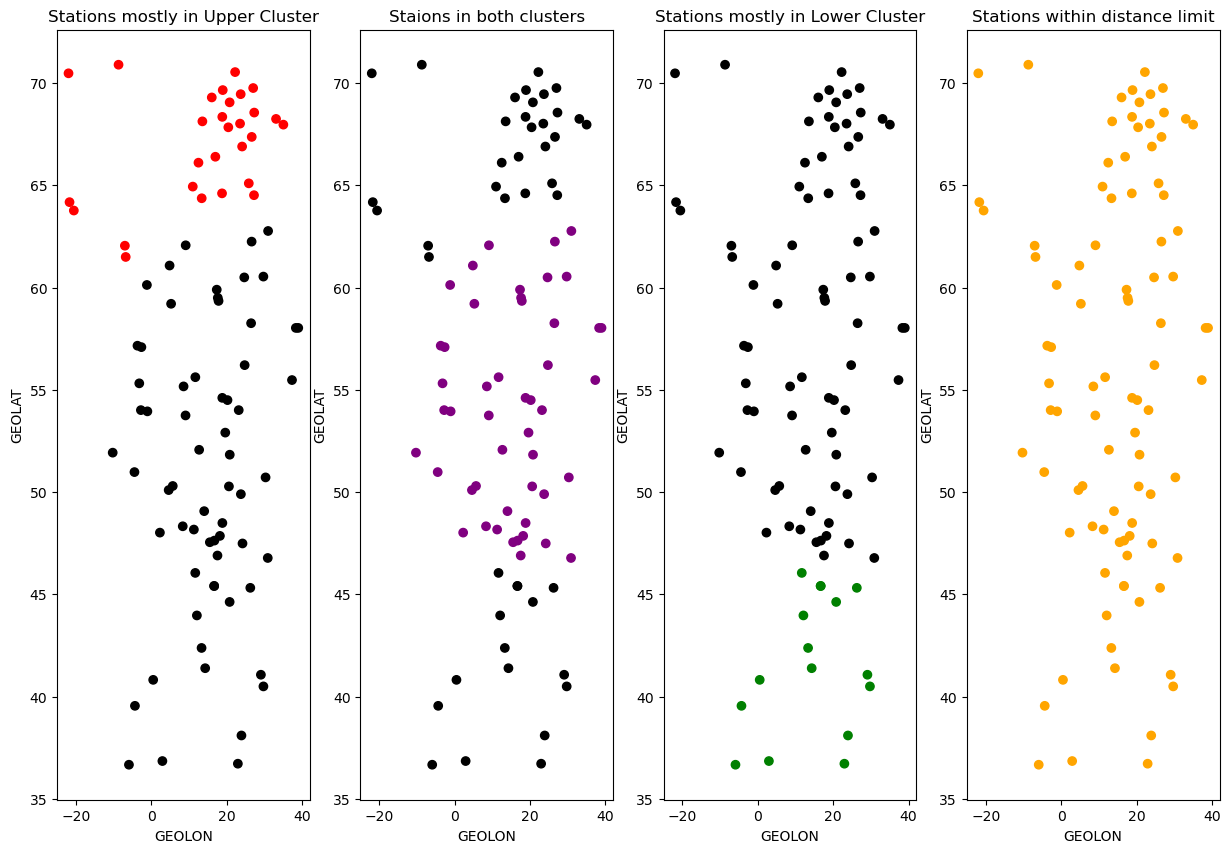

In [157]:
fig = plt.figure(figsize=(15,10))
ax1 = plt.subplot(141)
plt.scatter(x=df['GEOLON'], y=df['GEOLAT'], c=df['upper_color'])
plt.margins(x=.05, y=.05)
plt.xlabel('GEOLON')
plt.ylabel('GEOLAT')
ax1.set_title('Stations mostly in Upper Cluster')

ax2 = plt.subplot(142)
plt.scatter(x=df['GEOLON'], y=df['GEOLAT'], c=df['mid_color'])
plt.margins(x=.05, y=.05)
plt.xlabel('GEOLON')
plt.ylabel('GEOLAT')
ax2.set_title('Staions in both clusters')

ax3 = plt.subplot(143)
plt.scatter(x=df['GEOLON'], y=df['GEOLAT'], c=df['low_color'])
plt.margins(x=.05, y=.05)
plt.xlabel('GEOLON')
plt.ylabel('GEOLAT')
ax3.set_title('Stations mostly in Lower Cluster')

ax4 = plt.subplot(144)
plt.scatter(x=df['GEOLON'], y=df['GEOLAT'], c=df['limit_color'])
plt.margins(x=.05, y=.05)
plt.xlabel('GEOLON')
plt.ylabel('GEOLAT')
ax4.set_title('Stations within distance limit')
plt.show()